In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes
from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [4]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 15/15 [00:00<00:00, 31.26it/s]

CPU times: user 77.3 ms, sys: 93.6 ms, total: 171 ms
Wall time: 483 ms


## Subset of reads with at least 3 transitions

In [56]:
%%time
dense_reads_with_detection_df = (reads_df
    .select(
        'read_name',
        'read_length',
        'chrom',
        'sample_id',
        'grch37_chromosome_size_in_bp',
        'high_quality_snp_positions',
        'CO_active_interval_start',
        'CO_active_interval_end',
        'CO_active_interval_length_bp',
        'grch37_reference_start',
        'grch38_reference_start',
        'grch37_reference_end',
        'grch38_reference_end',
        'grch37_reference_start_cM',
        'grch37_reference_end_cM',
        'CO_active_interval_start_cM',
        'CO_active_interval_end_cM',
        'CO_active_interval_crossover_prob',
        "mid_CO_active_interval_crossover_prob",
        'AA_motif_center_pos',
        'AA_heat',
        'AA_motif_strand',
        'CL4_motif_center_pos',
        'CL4_heat',
        'CL4_motif_strand',
        'is_high_quality_read',
        "min_coverage_hap1",
        "min_coverage_hap2",
        "high_quality_classification_class",
        "snp_positions_on_read", 
        "idx_transitions",
        "H3K4me3_signal_mean",
        "CTCF_signal_sum",
        "CTCF_signal_mean",
        "high_quality_classification_in_detectable_class",
        "full_read_crossover_prob",
    )
    #.filter(pl.col("idx_transitions").list.len() >= 3)
    .filter(pl.col("high_quality_classification_class") == "CNCO")
    .filter("is_high_quality_read")
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
    .collect(streaming=True)
)

CPU times: user 3min 28s, sys: 51.6 s, total: 4min 20s
Wall time: 1min 38s


# Basic stats

In [14]:
print("# of complex reads here:", len(dense_reads_with_detection_df))

# of complex reads here: 322


## Distribution of number of switches

In [17]:
n_switches_df = (dense_reads_with_detection_df
    .select(pl.col("idx_transitions").list.len().alias("n_switches"))
    .group_by("n_switches")
    .len()
    .sort("n_switches")
)

display(n_switches_df)

n_switches,len
u32,u32
3,88
4,91
5,32
6,34
7,23
8,20
9,15
10,5
11,6


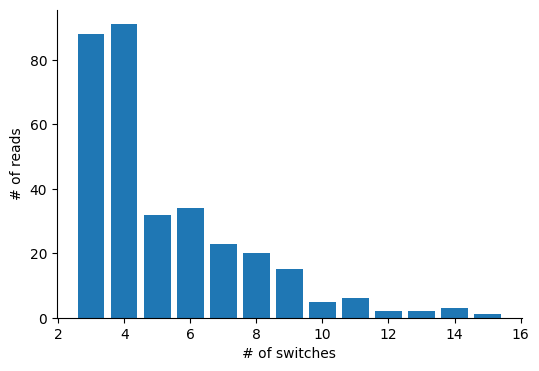

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(
    x = n_switches_df["n_switches"],
    height = n_switches_df["len"],
);

sns.despine(ax=ax);
ax.set_xlabel("# of switches");
ax.set_ylabel("# of reads");

In [28]:
def paint_complex_events(
    df,
    figsize=(10,8),
):

    complex_rows = df.rows(named=True)

    fig, ax = plt.subplots(figsize=figsize)

    for i, row in enumerate(complex_rows):

        ax.plot(
            [0, row["read_length"]],
            [i,i],
            color="black",
            lw=0.5,
            alpha=0.5,
        )

        colors = [0]
        for j in range(1, len(row["snp_positions_on_read"])):
            if j in row["idx_transitions"]:
                colors.append(1-colors[-1])
            else:
                colors.append(colors[-1])

        ax.scatter(
            x = row["snp_positions_on_read"],
            y = [i] * len(row["snp_positions_on_read"]),
            s = 6,
            c = [["blue", "red"][x] for x in colors],
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xlabel("Position in read (bp)");
    ax.set_yticks([], []); #np.arange(len(complex_rows)), np.arange(len(complex_rows)), fontsize=7);
    
    return ax

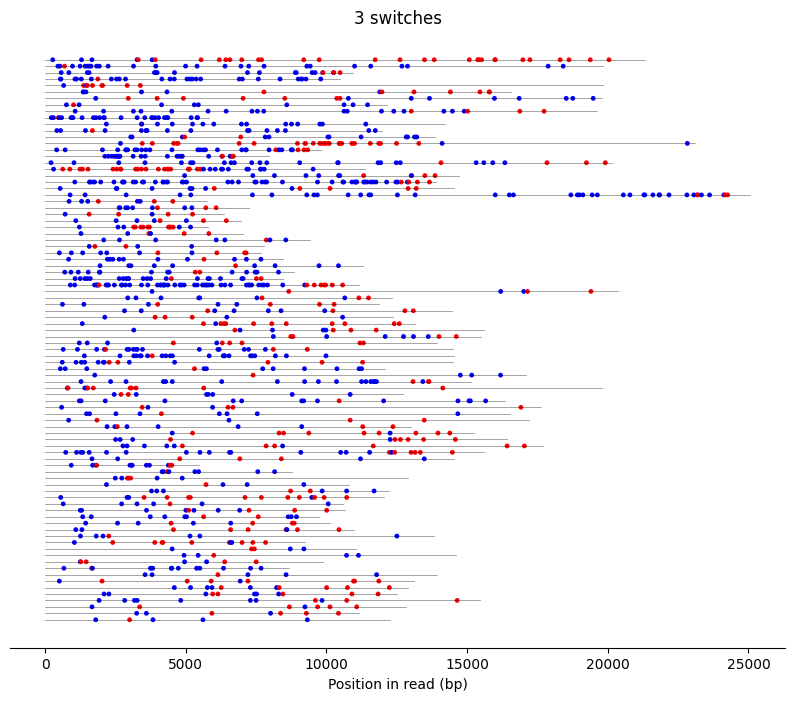

In [31]:
ax = paint_complex_events(
    (dense_reads_with_detection_df
        .filter(pl.col("idx_transitions").list.len() == 3)
    ),
    figsize=(10,8),
)

ax.set_title("3 switches");

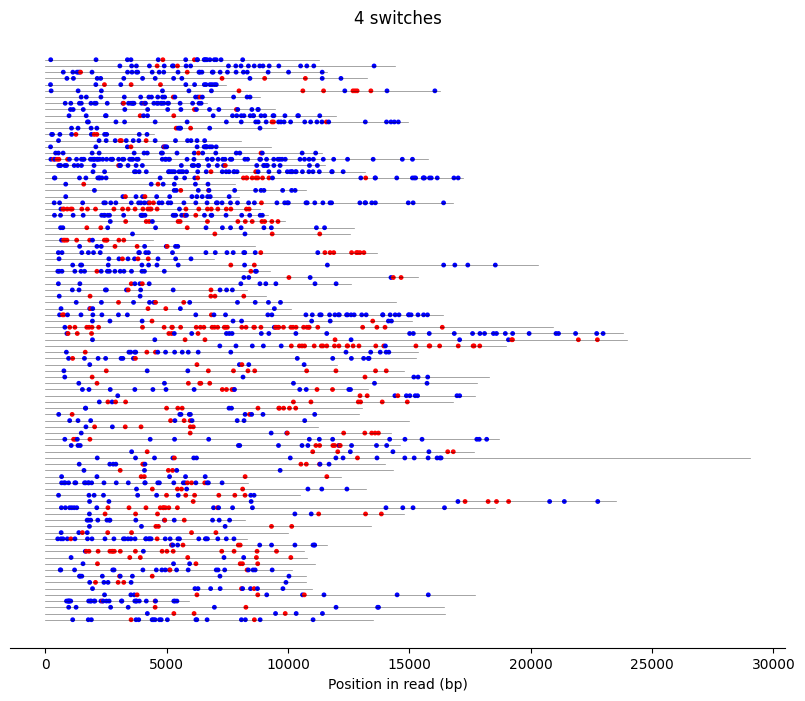

In [32]:
ax = paint_complex_events(
    (dense_reads_with_detection_df
        .filter(pl.col("idx_transitions").list.len() == 4)
    ),
    figsize=(10,8),
)

ax.set_title("4 switches");

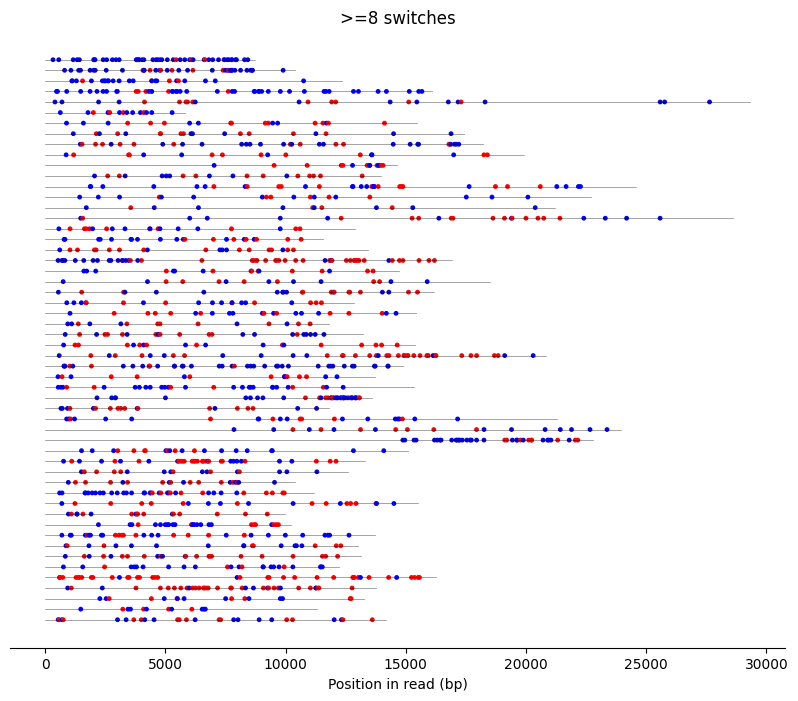

In [33]:
ax = paint_complex_events(
    (dense_reads_with_detection_df
        .filter(pl.col("idx_transitions").list.len() >= 8)
    ),
    figsize=(10,8),
)

ax.set_title(">=8 switches");

# Genetic length distribution

In [34]:
dense_reads_with_detection_df.columns

['read_name',
 'read_length',
 'chrom',
 'sample_id',
 'grch37_chromosome_size_in_bp',
 'high_quality_snp_positions',
 'CO_active_interval_start',
 'CO_active_interval_end',
 'CO_active_interval_length_bp',
 'grch37_reference_start',
 'grch38_reference_start',
 'grch37_reference_end',
 'grch38_reference_end',
 'grch37_reference_start_cM',
 'grch37_reference_end_cM',
 'CO_active_interval_start_cM',
 'CO_active_interval_end_cM',
 'CO_active_interval_crossover_prob',
 'mid_CO_active_interval_crossover_prob',
 'AA_motif_center_pos',
 'AA_heat',
 'AA_motif_strand',
 'CL4_motif_center_pos',
 'CL4_heat',
 'CL4_motif_strand',
 'is_high_quality_read',
 'min_coverage_hap1',
 'min_coverage_hap2',
 'high_quality_classification_class',
 'snp_positions_on_read',
 'idx_transitions',
 'H3K4me3_signal_mean',
 'CTCF_signal_sum',
 'CTCF_signal_mean',
 'high_quality_classification_in_detectable_class']

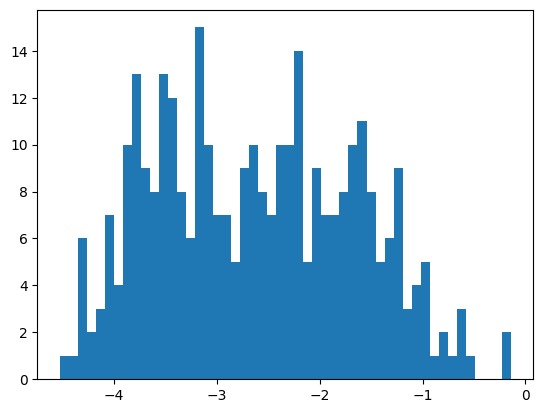

In [57]:
plt.hist(
    (dense_reads_with_detection_df["full_read_crossover_prob"]*1e2).log10(),
    bins=50,
);

In [58]:
(
    dense_reads_with_detection_df["full_read_crossover_prob"]*1e2 / 
    (dense_reads_with_detection_df["read_length"] / 1e6)
).mean()

1.3579688583203295

# Does it have hostpots

In [44]:
dense_reads_with_detection_df.select(pl.col("AA_motif_center_pos").is_not_null()).mean()

AA_motif_center_pos
f64
0.15528


In [46]:
(dense_reads_with_detection_df
    .select(
        pl.col("idx_transitions").list.len().alias("n_trans"),
        pl.col("AA_motif_center_pos").is_not_null().alias("has_dsb"),
    )
    .group_by("n_trans")
    .agg(pl.col("has_dsb").mean())
    .sort("n_trans")
)

n_trans,has_dsb
u32,f64
3,0.181818
4,0.120879
5,0.1875
6,0.264706
7,0.130435
8,0.15
9,0.066667
10,0.0
11,0.166667


# Compare numbers between individuals]

In [47]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 15/15 [00:00<00:00, 20.82it/s]

CPU times: user 194 ms, sys: 208 ms, total: 402 ms
Wall time: 757 ms


In [48]:
%%time
candidates_df = (reads_df
    .select(
        'read_name',
        'chrom',
        'sample_id',
        'is_high_quality_read',
        "high_quality_classification_class",
        "high_quality_classification_in_detectable_class",
    )
    .filter("is_high_quality_read")
    .filter(pl.col("high_quality_classification_class").is_not_null())
    .collect(streaming=True)
)

CPU times: user 34.4 s, sys: 6.22 s, total: 40.6 s
Wall time: 30.6 s


In [49]:
len(candidates_df)

9679

In [50]:
call_stats_df = (candidates_df    
    .pivot(
        values=["high_quality_classification_class"],
        index=["sample_id"],
        columns=["high_quality_classification_class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
)

call_stats_df = (
    pl.DataFrame(
        {
            "sample_id": sample_presentation_order, 
            "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
        }
    )
    .join(call_stats_df, on="sample_id")
)

with pl.Config(tbl_rows=40):
    display(call_stats_df.drop("sample_id"))

paper_label_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
"""AA1-s1""",161,45,95,3
"""AA1-s2""",130,31,78,8
"""AA2-t1""",262,72,135,45
"""AA2-t2""",179,82,110,54
"""AA3""",205,73,126,31
"""AA4""",180,51,80,24
"""AA5""",520,233,419,13
"""AA6""",447,212,326,11
"""AA7""",501,212,346,18


In [59]:
call_stats_df.sum()

sample_id,paper_label_id,CO,GC,ambiguous,CNCO
str,str,u32,u32,u32,u32
null,null,4460,1759,3109,351


In [55]:
import scipy.stats

cont = np.array(
    [call_stats_df["CNCO"].to_numpy(), (call_stats_df["CO"]+call_stats_df["GC"]+call_stats_df["ambiguous"]).to_numpy()]
)

scipy.stats.chi2_contingency(cont)

Chi2ContingencyResult(statistic=389.5600391904709, pvalue=2.002452818846771e-74, dof=14, expected_freq=array([[  11.02427937,    8.95722699,   18.63973551,   15.41223267,
          15.77487344,   12.14846575,   42.97293109,   36.11902056,
          39.05641079,   35.21241864,   34.84977787,   19.83645005,
          15.37596859,   29.91786342,   15.70234528],
       [ 292.97572063,  238.04277301,  495.36026449,  409.58776733,
         419.22512656,  322.85153425, 1142.02706891,  959.88097944,
        1037.94358921,  935.78758136,  926.15022213,  527.16354995,
         408.62403141,  795.08213658,  417.29765472]]))